<a href="https://colab.research.google.com/github/werd0n4/hand-gesture-classification/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

---


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !ls

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os
import cv2
import glob
import random
from matplotlib import pyplot as plt

# Constant parameters

---



In [ ]:
horiz_x = 600  
vert_y = 480
#drive paths
#
imgs_train_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Train/'
imgs_test_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Test/'
#local paths
#
# imgs_train_path = 'C:\\Users\\Werdon\\Google Drive\\Colab Notebooks\\Rozszerzony_dataset\\Train'
# imgs_test_path = 'C:\\Users\\Werdon\\Google Drive\\Colab Notebooks\\Rozszerzony_dataset\\Train'

In [ ]:

class_names = {
    0: "1",
    1: "2",
    2: "3",
    3: "4",
    4: "5",
    5: "A",
    6: "B",
    7: "C",
    8: "D",
    9: "E",
    10: "F",
    11: "G",
    12: "H",
    13: "I",
    14: "K",
    15: "L",
    16: "M",
    17: "N",
    18: "O",
    19: "P",
    20: "R",
    21: "S",
    22: "T",
    23: "U",
    24: "W",
    25: "Y",
    26: "Z"
}


# Auxiliary functions

---


## Image resize

In [ ]:

def resize(path):
    img_counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            resized_img = cv2.resize(img, (horiz_x, vert_y))
            cv2.imwrite(image_path, resized_img)
            img_counter += 1
    
    print('Images in set: ' + str(img_counter))


## Image size sanity check

In [ ]:

def sanity_check(path):
    counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            if img.shape != (horiz_x, vert_y, 3):
                counter += 1

    print('Sanity result: ' + str(counter))

In [ ]:

def show_img(index, X, Y):
    # plt.imshow(X[index])
    plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    nmb = int(np.where(Y[index] == 1)[0])
    print("On image: " + class_names[nmb])

## Load dataset

In [ ]:

def load_dataset():
    trainlist = glob.glob(f'{imgs_train_path}/*/*')
    testlist = glob.glob(f'{imgs_test_path}/*/*')
    X_train = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in trainlist] )
    X_test = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in testlist] )

    # Y_train = np.array([np.zeros(27) for fname in trainlist])
    Y_train = np.array([0 for fname in trainlist])
    for i,fname in enumerate(trainlist):
        img_id = fname.split('/')[7]
        img_id = img_id.split('_')[0]
        # Y_train[i][img_id] = 1
        Y_train[i] = img_id


    # Y_test = np.array([np.zeros(27) for fname in testlist])
    Y_test = np.array([0 for fname in testlist])
    for i,fname in enumerate(testlist):
        img_id = fname.split('/')[7]
        img_id = img_id.split('_')[0]
        # Y_test[i][img_id] = 1
        Y_test[i] = img_id

    return X_train, Y_train, X_test, Y_test


## Create network model

In [ ]:

def create_model():
    model = Sequential()
    # initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    initializer = None
    activ_func = 'relu'

    # CONVOLUTIONAL LAYER
    model.add(Conv2D(
        filters=6, 
        kernel_size=(5,5), 
        input_shape=(vert_y, horiz_x, 3), 
        activation=activ_func,
        kernel_initializer=initializer
    ))

    # POOLING LAYER
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    # CONVOLUTIONAL LAYER
    model.add(Conv2D(
        filters=16, 
        kernel_size=(5,5), 
        activation=activ_func,
        kernel_initializer=initializer
    ))

    # POOLING LAYER
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    # CONVOLUTIONAL LAYER
    model.add(Conv2D(
        filters=32, 
        kernel_size=(5,5), 
        activation=activ_func,
        kernel_initializer=initializer
    ))

    # POOLING LAYER
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    # CONVOLUTIONAL LAYER
    model.add(Conv2D(
        filters=120, 
        kernel_size=(5,5), 
        activation=activ_func,
        kernel_initializer=initializer
    ))

    # POOLING LAYER
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(27, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', 
        metrics=['accuracy']
    )

    return model


# Loading dataset

---


## Resize images and do sanity check

In [ ]:
# Uncomment before first run on dataset 
resize(imgs_train_path)
sanity_check(imgs_train_path)
resize(imgs_test_path)
sanity_check(imgs_test_path)


Images in set: 1561
Sanity result: 1561
Images in set: 297
Sanity result: 297


In [ ]:
X_train, Y_train, X_test, Y_test = load_dataset()

In [ ]:
# One hot encoding
Y_cat_train = to_categorical(Y_train, 27)
Y_cat_test = to_categorical(Y_test, 27)

## Data augumentation

## Initializing ImageDataGenerator class

In [ ]:
image_gen = ImageDataGenerator(rotation_range=5, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                            #    rescale=1.1, # Rescale the image by normalzing it.
                               shear_range=0.05, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.05, # Zoom in by 10% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                                )
                              

## Augumentation sample result

In [ ]:
#augumentation sample result

#original img
# nmb = random.randint(0, 296)
# my_hand = X_test[nmb]
# show_img(nmb, X_test, Y_cat_test)

# #generated img
# gen_img = image_gen.random_transform(my_hand)
# print("Generated image")
# plt.imshow(cv2.cvtColor(gen_img,cv2.COLOR_BGR2RGB).astype('float32'))
# plt.show()

# comparison = my_hand == gen_img
# equal_arrays = comparison.all()
# print("Images are equal?: " + str(equal_arrays))

## Image shape and batch size initialization

In [ ]:
image_shape = (horiz_x, vert_y, 3)
batch_size = 8

print(imgs_train_path)
print(imgs_test_path)

/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Train/
/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Test/


## Initializing test and train image geneartors

In [ ]:
train_image_gen = image_gen.flow_from_directory(imgs_train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 1561 images belonging to 27 classes.


In [ ]:
test_image_gen = image_gen.flow_from_directory(imgs_test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 297 images belonging to 27 classes.


In [ ]:
#train_image_gen.class_indices

# Create and train model

---


In [ ]:
CNN = create_model()
CNN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 476, 596, 6)       456       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 238, 298, 6)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 234, 294, 16)      2416      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 117, 147, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 113, 143, 32)      12832     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 56, 71, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 52, 67, 120)      

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
#Y_cat_train.shape

## Fit model

In [ ]:
CNN.fit(X_train, Y_cat_train, epochs=12, validation_data=(X_test, Y_cat_test), batch_size=batch_size, callbacks=[early_stop])

Epoch 1/12
98/98 [==============================] - 17s 175ms/step - loss: 0.7313 - accuracy: 0.7726 - val_loss: 3.5923 - val_accuracy: 0.3468
Epoch 2/12
98/98 [==============================] - 17s 173ms/step - loss: 0.4213 - accuracy: 0.8924 - val_loss: 4.4365 - val_accuracy: 0.3064
Epoch 3/12
98/98 [==============================] - 17s 174ms/step - loss: 0.2001 - accuracy: 0.9417 - val_loss: 5.4065 - val_accuracy: 0.2963


## Fit model with data augumentation

In [ ]:
# results = CNN.fit(train_image_gen, epochs=20, validation_data=test_image_gen, callbacks=[early_stop])

## Saving model to file

In [ ]:
CNN.save('hand_gesture_classifier.h5')

# Results

---


In [ ]:
metrics = pd.DataFrame(CNN.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,3.323655,0.032031,3.295861,0.037037
1,3.296093,0.032671,3.295913,0.037037


## Single image prediction

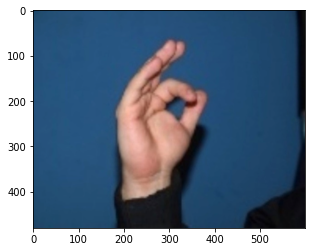

On image: F


In [ ]:
nmb = 2
my_hand = X_test[nmb]
show_img(nmb, X_test, Y_cat_test)

In [ ]:
my_hand = my_hand.reshape(1, vert_y, horiz_x, 3)
result = CNN.predict_classes(my_hand)
# result = (CNN.predict(my_hand) > 0.5).astype("int32")
result = int(result)
print('CNN says: ' + class_names[result])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
CNN says: I


## Predictions for individual classes

In [ ]:
predictions = CNN.predict_classes(X_test)

In [ ]:
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00        11
          13       0.04      1.00      0.07        11
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00        11
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
